In [5]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import math
import time

In [6]:
seed_num =  35
rnd = np.random
rnd.seed(seed_num)

In [3]:
#Parameters Declare:
n = 15 #number of clients
H = 6 # number of time periods
m = 3 #number of vehicle
mip_gap =.1
T = np.arange(1,H+1) # Time horizon index

r_sub = rnd.randint(10,100,size = n+1)
r = r_sub
for i in range(H-1):
    r =np.column_stack((r,r_sub))

r[0] = np.zeros((H,),dtype = int)
for i in range(1,n+1):
    r[0] = r[0]+ r[i] #made available units in depot
N_phay = np.arange(1,n+1) #client index
N = np.arange(0,n+1) #node index
U = rnd.choice((2,3),1)[0]*r[:,1] #maximum inventory level
I_0 = U-r[:,1] #Initial inventory level array
I_0[0]=np.sum(U[1:])
h =  rnd.randint(1,5,size =n+1) #holding cost
h[0] = 3

Q = 3/(2*m)*np.sum(r[1:,1]) # vehicle capacity

loc_x = rnd.rand(len(N))*500
loc_y = rnd.rand(len(N))*500
Cost = {(i,j): round(np.hypot(loc_x[i]-loc_x[j],loc_y[i]-loc_y[j]))for i in N for j in N if i!=j} #Moving cost matrix

Cost_2 = {(i,j): round(np.hypot(loc_x[i]-loc_x[j],loc_y[i]-loc_y[j]))for i in N for j in N if i<j} #Moving cost matrix2
cost_2_list = list(Cost_2.values())
cost_list_ultimate =[]
for i in range(len(cost_2_list)):
    for j in range(H):
        cost_list_ultimate += [cost_2_list[i]]
#cost_list_ultimate là chi phí ứng với từng y_i_j_t, khác với cost là ma trận chi phí di chuyển từ i đến j

rho = 10
mu = 10
epsilon =10**-6
epsilon_2 = 10**-1

In [4]:
rho = 15
mu =15

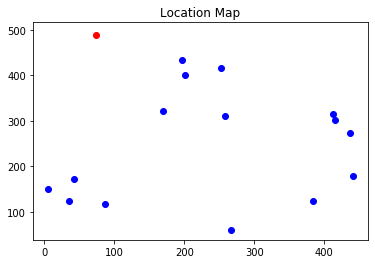

In [5]:
plt.scatter(loc_x[1:],loc_y[1:], c = 'b')
plt.scatter(loc_x[0],loc_y[0],c ='r')
plt.title('Location Map')
plt.show()

In [6]:
#Variable for easy indexing:
E = [(i,j) for i in N for j in N if i<j]
A = [(i,j) for i in N for j in N if i!=j]
E_with_T =  [(i,j,t) for i in N for j in N for t in T if i<j]
A_with_T = [(i,j,t) for i in N for j in N for t in T if i!=j] #set A with T
it_set = [(i,t) for i in N for t in T]
it_set_customer_only = [(i,t) for i in N_phay for t in T]

In [7]:
len_0 = len(E_with_T)  #0 -> y
len_1 = len_0 + len(it_set_customer_only) #len 0-> q
len_2 = len_1 + len(it_set) #len 0-> z
len_3 = len_2 + len(A_with_T) #len 0-> load
len_4 = len_3 + len(A_with_T) #len 0-> x
len_5 = len_4 + len(it_set) #len 0-> I

Since $$H_1(x) = 1/2 \rho \lVert x^k \rVert - lnf(x) - \mu P(x) $$ then <br>
$$y^k = \nabla H_1 (x^k) = \rho x^k -\nabla lnf(x^k) - \mu P(x^k)$$<br>
$P(X) =\sum(1-x)x $

Calculate $\rho x$ aka 1stTerm in the above equation ($y_k = ...$)

In [8]:
def d_1st_term(X):
    return rho*np.asarray(X)

Calculate $\nabla ln(ax)$

In [9]:
def d_2nd_term(X,coef):
    result = X*coef/np.dot(X,coef)
    return result

Calculate $\nabla P(x)$

In [10]:
def d_3rd_term(X):
    return mu*(1-2*np.asarray(X))

In [11]:
def cal_y_k(X):
    result = np.zeros(len(X))
    result += d_1st_term(X)
    result[0:len_0] += -d_2nd_term(X[0:len_0],cost_list_ultimate) #loga nepe tu so
    result[len_0:len_1] += d_2nd_term(X[len_0:len_1],np.ones(len_1-len_0)) #loge nepe mauso
    result[0:len_0] += -d_3rd_term(X[0:len_0])
    result[len_1:len_2] += -d_3rd_term(X[len_1:len_2])
    result[len_3:len_4] += -d_3rd_term(X[len_3:len_4])
    return result

In [12]:
def solve_DCA(y_k,zero_one_indices_cut =False):
    model = Model("Graduation Thesis by ThaoNgCh") 
    
    #Variables Declaration:
    y = model.continuous_var_dict(E_with_T,lb = 0,ub = 1,name = 'y')
    q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') 
    z = model.continuous_var_dict(it_set,lb = 0,ub = 1,name ='z') 
    load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') 
    x = model.continuous_var_dict(A_with_T,lb = 0,ub = 1,name = 'x') 
    I = model.continuous_var_dict(it_set,lb = 0,name = 'I') 

#     y = model.integer_var_dict(E_with_T,lb = 0,ub =1,name = 'y') #Check
#     q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
#     z = model.binary_var_dict(it_set,name ='z') #Check
#     load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
#     x = model.binary_var_dict(A_with_T,ub =1,name = 'x') #Check
#     I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check

    #Objective Function
    G = model.sum(y[i]**2 for i in E_with_T)
    G += model.sum(q[i]**2 for i in it_set_customer_only)
    G += model.sum(z[i]**2 for i in it_set)
    G += model.sum(load[i]**2 for i in A_with_T)
    G += model.sum(x[i]**2 for i in A_with_T)
    G+= model.sum(I[i]**2 for i in it_set)
    G = 1/2*rho*G
    
    
    H  = model.sum(y[i]*y_k[0:len_0][j] for i,j in zip(E_with_T,range(len(y_k))))
    H += model.sum(q[i]*y_k[len_0:len_1][j] for i,j in zip(it_set_customer_only,range(len(y_k))))
    H += model.sum(z[i]*y_k[len_1:len_2][j] for i,j in zip(it_set,range(len(y_k))))
    H += model.sum(load[i]*y_k[len_2:len_3][j] for i,j in zip(A_with_T,range(len(y_k))))
    H += model.sum(x[i]*y_k[len_3:len_4][j] for i,j in zip(A_with_T,range(len(y_k))))
    H += model.sum(I[i]*y_k[len_4:len_5][j] for i,j in zip(it_set,range(len(y_k))))
    
    model.minimize(G-H)
    
    #Add constraints
    model.add_constraint(model.sum((model.sum(Cost[i,j]*y[i,j,t] for t in T) for (i,j) in E))<=(current_local_val-epsilon_2)*model.sum(model.sum(q[i,t] for t in T) for i in N_phay)) #BOund Constraints
    model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
    model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
    model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
    model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
    model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
    model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
    model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
    model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
    #model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
    model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
    model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)- model.sum(load[j,i,t] for j in N if(j,i) in A) == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
    model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A) - model.sum(load[j,0,t] for j in N if (j,0) in A) == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
    model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
    model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
    model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
    model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
    #model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
    #model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50
    
    #cut current solution
    if zero_one_indices_cut ==True:
        model.add_constraint(model.sum(1-y[list(y)[i]] for i in one_indices_y)
                             +model.sum(1-z[list(z)[i]] for i in one_indices_z)
                             +model.sum(1-x[list(x)[i]] for i in one_indices_x)
                             +model.sum(y[list(y)[i]] for i in zero_indices_y)
                             +model.sum(z[list(z)[i]] for i in zero_indices_z)
                             +model.sum(x[list(x)[i]] for i in zero_indices_x) >=1)
    
    model.parameters.mip.tolerances.mipgap = mip_gap #set gap
    model.parameters.timelimit = 1200
    model.export_as_lp()
    solution = model.solve()#(log_output = True)
    if solution == None:
        return 'None','None','None'
    y_k = cal_y_k(np.asarray(solution.get_all_values()))
    tu_so = np.dot(solution.get_values(y[i] for i in E_with_T),cost_list_ultimate)
    mau_so = np.dot(solution.get_values(q[i] for i in it_set_customer_only),np.ones(len(q)))
    real_obj_value = tu_so/mau_so
    return solution,y_k,real_obj_value

## Find Initial Solution min tu so

In [13]:
# model = Model("Archetti 2014 Model by ThaoNgCh")

# #Variables Declare:
# y = model.integer_var_dict(E_with_T,lb = 0,name = 'y') #Check
# q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
# z = model.binary_var_dict(it_set,name ='z') #Check
# load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
# x = model.binary_var_dict(A_with_T,name = 'x') #Check
# I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check

# #Objective Function
# model.minimize(model.sum((model.sum(Cost[i,j]*y[i,j,t] for t in T) for (i,j) in E))) 

# #Add constraints
# model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
# model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
# model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
# model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
# model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
# #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
# #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
# model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
# model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
# model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
# #model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
# model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
# model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)
#                       - model.sum(load[j,i,t] for j in N if(j,i) in A) 
#                       == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
# model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A)
#                       - model.sum(load[j,0,t] for j in N if (j,0) in A) 
#                       == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
# model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
# model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
# model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
# model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
# model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
# #model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50

# #model.add_constraint(model.sum(model.sum(q[i,t] for t in T) for i in N_phay) >=dMin) #z(D)>= D_k_min
# model.parameters.mip.tolerances.mipgap = mip_gap #set gap
# model.parameters.timelimit = 6000
# x_0_3 = model.solve(log_output = True)#(log_output = True)

### Find init max mau so

In [14]:
model = Model("Archetti 2014 Model by ThaoNgCh")

#Variables Declare:
y = model.integer_var_dict(E_with_T,lb = 0,name = 'y') #Check
q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
z = model.binary_var_dict(it_set,name ='z') #Check
load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
x = model.binary_var_dict(A_with_T,name = 'x') #Check
I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check

#Objective Function
model.maximize(model.sum(model.sum(q[i,t] for t in T) for i in N_phay)) #Maximizing z(D)

#Add constraints
model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
#model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
#model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
#model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)
                      - model.sum(load[j,i,t] for j in N if(j,i) in A) 
                      == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A)
                      - model.sum(load[j,0,t] for j in N if (j,0) in A) 
                      == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
#model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50

#model.add_constraint(model.sum(model.sum(q[i,t] for t in T) for i in N_phay) >=dMin) #z(D)>= D_k_min
model.parameters.mip.tolerances.mipgap = mip_gap #set gap
model.parameters.timelimit = 6000
x_0_mau_so = model.solve(log_output = True)#(log_output = True)

CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               6000
CPXPARAM_MIP_Tolerances_MIPGap                   0.10000000000000001
Tried aggregator 2 times.
MIP Presolve eliminated 891 rows and 22 columns.
MIP Presolve modified 30 coefficients.
Aggregator did 18 substitutions.
Reduced MIP has 2631 rows, 3842 columns, and 13024 nonzeros.
Reduced MIP has 2250 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.00 ticks)
Probing time = 0.02 sec. (0.90 ticks)
Tried aggregator 1 time.
Reduced MIP has 2631 rows, 3842 columns, and 13024 nonzeros.
Reduced MIP has 2250 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (9.47 ticks)
Probing time = 0.00 sec. (1.02 ticks)
Clique table members: 4770.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.09 sec. (41.94 ticks)

        Nodes    

In [15]:
# x_0  =best_nghiem.get_all_values()

# x_k = np.asarray(x_0)
# init_obj_value = np.dot(x_k[0:len_0],cost_list_ultimate)/np.sum(x_k[len_0:len_1])

# print('Initial Value is ',init_obj_value)
# y_k = cal_y_k(x_k)
# while True:
#     x_k_old = np.asarray(x_k)
#     solve_DCA(y_k)
#     sol,y_k,real_obj_value = solve_DCA(y_k)
#     cur_sol = sol.objective_value
#     x_k = np.asarray(sol.get_all_values())
#     diff = x_k-x_k_old
#     print('Current Optimal Value is ',real_obj_value)
#     if np.dot(diff,diff) <= epsilon*(np.dot(x_k,x_k)+1):
#         print('Finished, Optimal Value is ',real_obj_value)
#         break
        

# DA3

In [16]:
def solve_upper(dMin):
    global D_min
    
    model = Model("Archetti 2018 Model upper by ThaoNgCh")
    
    #Variables Declare:
    y = model.integer_var_dict(E_with_T,lb = 0,name = 'y') #Check
    q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
    z = model.binary_var_dict(it_set,name ='z') #Check
    load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
    x = model.binary_var_dict(A_with_T,name = 'x') #Check
    I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check
    
    #Objective Function
    model.minimize(model.sum((model.sum(Cost[i,j]*y[i,j,t] for t in T) for (i,j) in E)))
    
    #Add constraints
    model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
    model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
    model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
    model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
    model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
    model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
    model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
    model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
    #model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
    model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
    model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)- model.sum(load[j,i,t] for j in N if(j,i) in A) == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
    model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A) - model.sum(load[j,0,t] for j in N if (j,0) in A) == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
    model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
    model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
    model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
    model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
    model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
    model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50
    
    model.add_constraint(model.sum(model.sum(q[i,t] for t in T) for i in N_phay) >=dMin) #z(D)>= D_k_min
    model.parameters.mip.tolerances.mipgap = mip_gap #set gap
    model.parameters.timelimit = 1800
    solution = model.solve()#(log_output = True)
    if solution == None:
        return "r_best",r_best
    else:
        return "z_R_star",solution.get_objective_value(),solution

In [17]:
def solve_below(zRStar):
    global D_min
    global z_R_star
    model = Model("Archetti 2018 Model below by ThaoNgCh")
    
    #Variables Declare:
    y = model.integer_var_dict(E_with_T,lb = 0,name = 'y') #Check
    q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
    z = model.binary_var_dict(it_set,name ='z') #Check
    load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
    x = model.binary_var_dict(A_with_T,name = 'x') #Check
    I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check
    
    #Objective Function
    model.maximize(model.sum(model.sum(q[i,t] for t in T) for i in N_phay)) #Maximizing z(D)
    
    #Add constraints
    model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
    model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
    model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
    model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
    model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
    model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
    model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
    model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
    #model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
    model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
    model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)- model.sum(load[j,i,t] for j in N if(j,i) in A) == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
    model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A) - model.sum(load[j,0,t] for j in N if (j,0) in A) == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
    model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
    model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
    model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
    model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
    model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
    model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50
    
    #Differences come from here
    model.add_constraint(model.sum(model.sum(Cost[i,j]*y[i,j,t] for t in T) for (i,j) in E) <= zRStar) #status_upper[1] is z*(R) value 
    model.parameters.mip.tolerances.mipgap = mip_gap #set gap
    model.parameters.timelimit = 1800 # set time_limit = 10 mins
    solution = model.solve()#(log_output = True)
    if solution == None:
        return "cant_solve",r_best
    else:
        return "z_D_star",solution.get_objective_value(),solution

### Find $x_0$.2

In [18]:
def solve_upper_minus_t_below(t):
    #global D_min
    
    model = Model("Archetti 2018 Model upper by ThaoNgCh")
    
    #Variables Declare:
    y = model.integer_var_dict(E_with_T,lb = 0,name = 'y') #Check
    q = model.continuous_var_dict(it_set_customer_only,lb = 0, name = 'q') #Check
    z = model.binary_var_dict(it_set,name ='z') #Check
    load = model.continuous_var_dict(A_with_T,lb=0,name = 'load') #...
    x = model.binary_var_dict(A_with_T,name = 'x') #Check
    I = model.continuous_var_dict(it_set,lb = 0,name = 'I') #Check
    
    #Objective Function
    model.minimize(model.sum((model.sum(Cost[i,j]*y[i,j,t] for t in T) for (i,j) in E))-t*model.sum(model.sum(q[i,t] for t in T) for i in N_phay))
    
    #Add constraints
    model.add_constraints(I[0,t] == I_0[0]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t ==1) #35
    model.add_constraints(I[0,t] == I[0,t-1]+r[0,t-1] -model.sum(q[i,t] for i in N_phay) for t in T if t>1) #35.5
    model.add_constraints(I[i,t] == I_0[i] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t ==1) #36
    model.add_constraints(I[i,t] == I[i,t-1] - r[i,t-1]+q[i,t] for i in N_phay for t in T if t >1) #36.5
    model.add_constraints(I[i,t] >=0 for i in N for t in T) #(37)
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I_0[i] for i in N_phay for t in T if t==1) #38
    #model.add_constraints(q[i,t] >=U[i]*z[i,t] - I[i,t-1] for i in N_phay for t in T if t>1) #38.5
    model.add_constraints(q[i,t] <= U[i] - I_0[i] for i in N_phay for t in T if t==1) #39
    model.add_constraints(q[i,t] <= U[i] - I[i,t-1] for i in N_phay for t in T if t>1) #39.5
    model.add_constraints(q[i,t] <=U[i]*z[i,t] for i in N_phay for t in T) #40
    #model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) == 2*z[i,t] for i in N_phay for t in T) #41
    model.add_constraints(model.sum(y[i,j,t] for j in N if (i,j) in E) +model.sum(y[j,i,t] for j in N if (j,i) in E) == 2*z[i,t] for i in N_phay for t in T) #41,remastered
    model.add_constraints(model.sum(load[i,j,t] for j in N if (i,j) in A)- model.sum(load[j,i,t] for j in N if(j,i) in A) == -q[i,t] for i in N for t in T if i in N_phay) #42 #check
    model.add_constraints(model.sum(load[0,j,t] for j in N if (0,j) in A) - model.sum(load[j,0,t] for j in N if (j,0) in A) == model.sum(q[k,t] for k in N_phay) for t in T) #42.5 #prety check 
    model.add_constraints(load[i,j,t] <= Q*x[i,j,t] for [i,j] in A  for t in T) #43 check
    model.add_constraints(model.sum(x[j,i,t] for j in N if (j,i) in A) -model.sum(x[i,j,t] for j in N if (i,j) in A) ==0 for i in N for t in T) #44check
    model.add_constraints(x[i,j,t]+x[j,i,t] == y[i,j,t] for [i,j] in E for t in T) #45
    model.add_constraints(model.sum(x[0,j,t] for j in N if (0,j) in A) <= m for t in T) #46
    model.add_constraints(y[i,j,t] <= 1 for (i,j) in E for t in T) #49
    model.add_constraints(y[0,j,t] <= 2 for j in N_phay for t in T) #50
    
    #model.add_constraint(model.sum(model.sum(q[i,t] for t in T) for i in N_phay) >=dMin) #z(D)>= D_k_min
    model.parameters.mip.tolerances.mipgap = mip_gap #set gap
    model.parameters.timelimit = 1800
    solution = model.solve()#(log_output = True)
    if solution == None:
        return "r_best",r_best
    else:
        return "z_R_star",solution.get_objective_value(),solution

In [19]:
k =0
r_best = float('inf')
D_min = 0

#Calculate D_max
sum1 = 0
sum2 = 0
for i in N_phay:
    sum1 =sum1 + max(np.array([r[i,t-1] for t in range(1,m+1)]).sum() - I_0[i],0)
for i in N_phay:
    sum2 =sum2 + (U[i]-r[i,H-1]- max(-np.array([r[i,t-1] for t in range(1,m+1)]).sum() + I_0[i],0))
D_max = min(H*Q*m,sum1+sum2)

# Intialize

In [20]:
#Algorithm from Project 3
print("seed = ",seed_num)
print("gap = ",mip_gap)
print("Number of customers = ",n)
print("Number of time periods = ",H)
print ("Number of vehicles = ",m)
start_time = time.time()
k=0
while True:
    print("\n-------Iteration number k= ",k+1,"-------")
    status_upper = solve_upper(D_min)
    if status_upper[0] =="r_best":
        break
    z_R_star = status_upper[1]
    print("z_R_star= ",z_R_star)
    
    #Lấy nghiệm sau lần solve upper đầu tiên
    if k==0:
        x_0_tu = status_upper
        
    if z_R_star >=r_best*D_max:#line 10
        break
        
    while True:
        D_bar_min = math.ceil(z_R_star/r_best) +1 #Line 13
        status_upper_bar = solve_upper(D_bar_min)
        if status_upper_bar[0] =="r_best": #line 15
            break
        if status_upper_bar[1] <=z_R_star:
            break
        else:
            z_R_star = status_upper_bar[1]
            print("z_R_star_bar = ",z_R_star)
    
    status_below = solve_below(z_R_star)
    z_D_star = status_below[1]
    print("z_D_star= ",z_D_star)
    
    elapsed_time = time.time()
    print("Elapsed time = ",elapsed_time- start_time)
    
    #Lấy nghiệm sau lần solve below đầu tiên
    if k==0:
        x_0_mau = status_below
    
    if (z_R_star/z_D_star <r_best):
        best_nghiem = status_below[2]
        best_z_R_star = z_R_star
        best_z_D_star = z_D_star
        r_best = z_R_star/z_D_star
        
    k = k +1
    D_min = z_D_star +1
    LB = z_R_star/D_max
    print("r_best = ",r_best)
    print("LB = ",LB)
    print ("D_min = ",D_min)
    if(r_best<LB):
        x_k = status_below[2].get_all_values()
        break
        
end_time = time.time()
print("The Optimal Ratio is :",r_best)
print("Got after ",k," iterations")
print("CPU time = ",end_time -start_time)
print("With the value of z_R_star = ",best_z_R_star)
print("With the value of z_D_star = ",best_z_D_star)
print("______________________________________________________________________________________________________")
#print ("CPU time = ",time.process_time ())

seed =  35
gap =  0.1
Number of customers =  15
Number of time periods =  6
Number of vehicles =  3

-------Iteration number k=  1 -------
z_R_star=  6932.0
z_D_star=  3791.0
Elapsed time =  1148.3871686458588
r_best =  1.8285412819836455
LB =  2.683701122725513
D_min =  3792.0
The Optimal Ratio is : 1.8285412819836455
Got after  1  iterations
CPU time =  1148.3881690502167
With the value of z_R_star =  6932.0
With the value of z_D_star =  3791.0
______________________________________________________________________________________________________


In [21]:
# x_0 = x_0_prime[2].get_all_values()

In [22]:
# #get x_0 by solve upper
# D_min = 0
# status_upper_once = solve_upper(D_min)
# x_0  =status_upper_once[2].get_all_values()

In [23]:
# #get x_0 by solving 1 iteration of Project 3 Algorithm
# status_upper = solve_upper(D_min)
# # if status_upper[0] =="r_best":
# #     break
# z_R_star = status_upper[1]
# print("z_R_star= ",z_R_star)
# # if z_R_star >=r_best*D_max:#line 10
# #     break
# while True:
#     D_bar_min = math.ceil(z_R_star/r_best) +1 #Line 13
#     status_upper_bar = solve_upper(D_bar_min)
#     if status_upper_bar[0] =="r_best": #line 15
#         break
#     if status_upper_bar[1] <=z_R_star:
#         break
#     else:
#         z_R_star = status_upper_bar[1]
#         print("z_R_star_bar = ",z_R_star)

# status_below = solve_below(z_R_star)
# z_D_star = status_below[1]
# print("z_D_star= ",z_D_star)
# if (z_R_star/z_D_star <r_best):
#     best_nghiem = status_below[2]
#     best_z_R_star = z_R_star
#     best_z_D_star = z_D_star
#     r_best = z_R_star/z_D_star
# k = k +1
# D_min = z_D_star +1
# LB = z_R_star/D_max
# print("r_best = ",r_best)
# print("LB = ",LB)
# print ("D_min = ",D_min)
# x_0 = np.asarray(best_nghiem.get_all_values())

In [24]:
# #get x_0 by solve upper - t below
# t = 0
# x_0 = solve_upper_minus_t_below(D_min,t)[2].get_all_values()
# print()

In [25]:
# rho =1.5*10**6
# mu = 10**5
# epsilon_2 = 10**-1

### mass \rho, \mu

In [26]:
result_tu_so_init =[]
result_mau_so_init = []

In [27]:
# #---------------------------------------MULTIPLE RHO, MU-------------------------------------------

# rho_list = np.array([15,150,1500,1.5*10**4,1.5*10**5,1.5*10**6,1.5*10**7])
# mu_list = np.array([10,100,1000,10000,10**5,10**6,10**7])

# #init = 'tu_so'
# init = 'mau_so'
# for i,j in zip(rho_list,mu_list):
#     rho,mu = i,j
#     #x_0  =best_nghiem.get_all_values()
#     print ('rho = ',rho)
#     print('mu = ', mu)
    
#     tic = time.time()
    
#     #Init x_0
#     if init=='tu_so':
#         x_0 = x_0_3.get_all_values() #init tu so
#     if init =='mau_so':
#         x_0 = x_0_mau_so.get_all_values() # init mau so
    
#     x_k = np.asarray(x_0)
#     losts =np.array([])
#     current_local_val = 100000000
#     init_obj_value = np.dot(x_k[0:len_0],cost_list_ultimate)/np.sum(x_k[len_0:len_1])
#     print('Initial Value is ',init_obj_value)
#     y_k = cal_y_k(x_k)
    
#     while True:
        
#         #Get penalty values:
#         p1 =x_k[0:len_0]
#         p2 =x_k[len_1:len_2]
#         p3 =x_k[len_3:len_4]
#         P = mu*np.dot(p1,1-p1)+np.dot(p2,1-p2) + np.dot(p3,1-p3)
#         print('Penalty value = ', P)
        
#         x_k_old = np.asarray(x_k)
#         solve_DCA(y_k)
#         sol,y_k,real_obj_value = solve_DCA(y_k)
#         cur_sol = sol.objective_value
#         losts = np.append(losts,real_obj_value)
#         x_k = np.asarray(sol.get_all_values())
#         diff = x_k-x_k_old
#         print('Current Optimal Value is ',real_obj_value)
#         if np.dot(diff,diff) <= epsilon*(np.dot(x_k,x_k)+1):
#             print('Finished, Optimal Value is ',real_obj_value)
            
#             #Save results to a list
#             if init =='tu_so':
#                 result_tu_so_init.append(real_obj_value)
#             if init =='mau_so':
#                 result_mau_so_init.append(real_obj_value)
                
#             break
#     toc = time.time()
#     print('Elapsed time = ',toc-tic)

#     #Plot
#     plt.plot(losts)
#     plt.ylabel('Objective Function')
#     plt.show()

In [28]:
# x_0_mau_so.objective_value

In [29]:
# result_mau_so_init

In [30]:
# result_tu_so_init

In [31]:
# #---------------------------------------SINGLE RHO, MU-------------------------------------------
# #x_0  =best_nghiem.get_all_values()
# rho = 15
# mu = 10
# print ('rho = ',rho)
# print('mu = ', mu)
# tic = time.time()
# x_k = np.asarray(x_0)
# losts =np.array([])
# current_local_val = 100000000
# init_obj_value = np.dot(x_k[0:len_0],cost_list_ultimate)/np.sum(x_k[len_0:len_1])
# print('Initial Value is ',init_obj_value)
# y_k = cal_y_k(x_k)
# while True:
#     p1 =x_k[0:len_0]
#     p2 =x_k[len_1:len_2]
#     p3 =x_k[len_3:len_4]
#     P = mu*np.dot(p1,1-p1)+np.dot(p2,1-p2) + np.dot(p3,1-p3)
#     #Get penalty values:
#     print('Penalty value = ', P)
#     x_k_old = np.asarray(x_k)
#     #solve_DCA(y_k)
#     sol,y_k,real_obj_value = solve_DCA(y_k)
#     cur_sol = sol.objective_value
#     losts = np.append(losts,real_obj_value)
#     x_k = np.asarray(sol.get_all_values())
#     diff = x_k-x_k_old
#     print('Current Optimal Value is ',real_obj_value)
#     if np.dot(diff,diff) <= epsilon*(np.dot(x_k,x_k)+1):
#         print('Finished, Optimal Value is ',real_obj_value)
#         print
#         break
# toc = time.time()
# print('Elapsed time = ',toc-tic)

# #Plot
# plt.plot(losts)
# plt.ylabel('Objective Function')
# plt.show()

### Add cut

$\sum_{j\in I_1}(1-x_j) +\sum_{j \in I_2}x_j \geq 1$

$I_1 = one\_indices = \{j:x_j = 1\} $

$I_2 = zero\_indices = \{j:x_j = 0\} $



In [32]:
# #Add mentioned above cut
# zero_indices= []
# zero_indices_y =[]
# zero_indices_z =[]
# zero_indices_x =[]
# one_indices = []
# one_indices_y = []
# one_indices_z = []
# one_indices_x = []
# for i in range(len_0):
#     if x_k[i]<0.1:
#         x_k[i] =0
#         zero_indices.append(i)
#         zero_indices_y.append(i)
#     else:
#         one_indices.append(i)
#         one_indices_y.append(i)
        
# for i in range(len_1,len_2):
#     if x_k[i]<0.1:
#         x_k[i] =0
#         zero_indices.append(i)
#         zero_indices_z.append(i-len_1)
#     else:
#         one_indices.append(i)
#         one_indices_z.append(i-len_1)
# for i in range(len_3,len_4):
#     if x_k[i]<0.1:
#         x_k[i] =0
#         zero_indices.append(i)
#         zero_indices_x.append(i-len_3)
#     else:
#         one_indices.append(i)
#         one_indices_x.append(i-len_3)
# #---------------------------------------SINGLE RHO, MU-------------------------------------------
# #x_0  =best_nghiem.get_all_values()
# rho = 15
# mu = 10
# print ('rho = ',rho)
# print('mu = ', mu)
# tic = time.time()
# #x_k = np.asarray(x_0)
# losts =np.array([])
# current_local_val = 100000000
# init_obj_value = np.dot(x_k[0:len_0],cost_list_ultimate)/np.sum(x_k[len_0:len_1])
# print('Initial Value is ',init_obj_value)
# y_k = cal_y_k(x_k)
# while True:
#     p1 =x_k[0:len_0]
#     p2 =x_k[len_1:len_2]
#     p3 =x_k[len_3:len_4]
#     P = mu*np.dot(p1,1-p1)+np.dot(p2,1-p2) + np.dot(p3,1-p3)
#     #Get penalty values:
#     print('Penalty value = ', P)
#     x_k_old = np.asarray(x_k)
#     #solve_DCA(y_k)
#     sol,y_k,real_obj_value = solve_DCA(y_k,zero_one_indices_cut=True)
#     cur_sol = sol.objective_value
#     losts = np.append(losts,real_obj_value)
#     x_k = np.asarray(sol.get_all_values())
#     diff = x_k-x_k_old
#     print('Current Optimal Value is ',real_obj_value)
#     if np.dot(diff,diff) <= epsilon*(np.dot(x_k,x_k)+1):
#         print('Finished, Optimal Value is ',real_obj_value)
#         print
#         break
# toc = time.time()
# print('Elapsed time = ',toc-tic)

# #Plot
# plt.plot(losts)
# plt.ylabel('Objective Function')
# plt.show()

In [33]:
# while True:
#     current_local_val = real_obj_value
#     init_obj_value = np.dot(x_k[0:len_0],cost_list_ultimate)/np.sum(x_k[len_0:len_1])
#     print('Initial Value is ',init_obj_value)
#     y_k = cal_y_k(x_k)
#     while True:
#         p1 =x_k[0:len_0]
#         p2 =x_k[len_1:len_2]
#         p3 =x_k[len_3:len_4]
#         P = mu*np.dot(p1,1-p1)+np.dot(p2,1-p2) + np.dot(p3,1-p3)
#         #Get penalty values:
#         print('Penalty value = ', P)
#         x_k_old = np.asarray(x_k)
#         solve_DCA(y_k)
#         sol,y_k,real_obj_value = solve_DCA(y_k)
#         cur_sol = sol.objective_value
#         losts = np.append(losts,real_obj_value)
#         x_k = np.asarray(sol.get_all_values())
#         diff = x_k-x_k_old
#         print('Current Optimal Value is ',real_obj_value)
#         if np.dot(diff,diff) <= epsilon*(np.dot(x_k,x_k)+1):
#             print('Finished, Optimal Value is ',real_obj_value)
#             print
#             break
#     toc = time.time()
#     print('Elapsed time = ',toc-tic)

rho =  15
mu =  10
t =  2
Initial Value is  1.7667441369110501
Penalty value =  0.0
Current Optimal Value is  1.7679725168595617
Finished, Optimal Value is  1.7679725168595617
Elapsed time =  1801.5895836353302
__________________________________________________________
rho =  15
mu =  10
t =  3
Initial Value is  1.8241382775600445
Penalty value =  0.0
Current Optimal Value is  1.8244972900762402
Finished, Optimal Value is  1.8244972900762402
Elapsed time =  535.6817815303802
__________________________________________________________
rho =  15
mu =  10
t =  4
Initial Value is  1.9456574478408544
Penalty value =  0.0
Current Optimal Value is  1.945810474329829
Finished, Optimal Value is  1.945810474329829
Elapsed time =  71.2530255317688
__________________________________________________________
rho =  15
mu =  10
t =  5
Initial Value is  1.9717083786724696
Penalty value =  0.0
Current Optimal Value is  1.9718620521922876
Finished, Optimal Value is  1.9718620521922876
Elapsed time =  14.

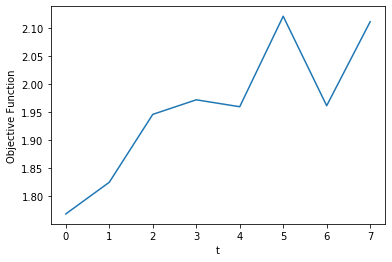

In [34]:
# tu so -t mau so
#plot t
losts = np.array([])
for t in range(2,10):
    tic = time.time()
    
    x_0 = solve_upper_minus_t_below(t)[2].get_all_values()
    #x_0  =best_nghiem.get_all_values()
    rho = 15
    mu = 10
    print ('rho = ',rho)
    print('mu = ', mu)
    print('t = ',t)
    
    x_k = np.asarray(x_0)
    #losts =np.array([])
    current_local_val = 100000000
    init_obj_value = np.dot(x_k[0:len_0],cost_list_ultimate)/np.sum(x_k[len_0:len_1])
    print('Initial Value is ',init_obj_value)
    y_k = cal_y_k(x_k)
    while True:
        p1 =x_k[0:len_0]
        p2 =x_k[len_1:len_2]
        p3 =x_k[len_3:len_4]
        P = mu*np.dot(p1,1-p1)+np.dot(p2,1-p2) + np.dot(p3,1-p3)
        #Get penalty values:
        print('Penalty value = ', P)
        x_k_old = np.asarray(x_k)
        solve_DCA(y_k)
        sol,y_k,real_obj_value = solve_DCA(y_k)
        cur_sol = sol.objective_value
        x_k = np.asarray(sol.get_all_values())
        diff = x_k-x_k_old
        print('Current Optimal Value is ',real_obj_value)
        if np.dot(diff,diff) <= epsilon*(np.dot(x_k,x_k)+1):
            losts = np.append(losts,real_obj_value)
            print('Finished, Optimal Value is ',real_obj_value)
            print
            break
    toc = time.time()
    print('Elapsed time = ',toc-tic)
    print("__________________________________________________________")

#Plot
plt.plot(losts)
plt.ylabel('Objective Function')
plt.xlabel('t')
plt.show()

In [35]:
D_min

3792.0